In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

from tqdm import tqdm
import pickle
#import h5py
import time

import numpy as np
import healpy as hp
#import scipy.interpolate as interpolate
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import jax.numpy as jnp
#from jax import jit, vmap

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils.units_constants import *
from utils.geometry import *
from utils.spectral import *
from utils.nfw import *
from utils.map_utils import *
#from utils.snr import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

2023-03-20 15:24:54.088413: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Comp/gcc/10.2.0-fasrc01/openmpi/4.1.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/glib/2.56.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/cudnn/8.2.2.26_cuda11.4-fasrc01/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/gcc/10.2.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/10.2.0-fasrc01/lib:/n/helmod/apps/centos7/Core/mpc/1.2.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/mpfr/4.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gmp/6.2.1-fasrc01/lib64
2023-03-20 15:24:54.088460: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_dr

## config

In [2]:
freq_arr = np.linspace(400, 800, 30) # [MHz]
field_model = 'AHgamma0p8'
run_name = f'field_{field_model}_check'

verbose = 0 # 0: nothing, 1: info, 2: debug
use_tqdm = True

SAVE_DIR = '../data/estimates'

## 1. run

In [44]:
## pre-loop
tot_SNR_arr = np.zeros_like(freq_arr)
if use_tqdm:
    pbar = tqdm(total=len(freq_arr))

## loop
for i_freq, freq in enumerate(freq_arr):

    if verbose >= 1:
        print('execution time (ms)', end='')
    ## 1. Map grid
    timer_start = time.time()
    CHIME_size_ra  = 80 * 100 # [cm]
    CHIME_size_dec = 100 * 100 # [cm]
    CHIME_ra_max = jnp.pi
    CHIME_ra_min = -jnp.pi
    CHIME_dec_max = jnp.deg2rad(90)
    CHIME_dec_min = jnp.deg2rad(-20)
    CHIME_dec = jnp.deg2rad(49.3)
    CHIME_extent = (180, -180, -20, 90)

    def ra_pixel_size(ra): # [rad]
        return (c0 / freq) / CHIME_size_ra
    def dec_pixel_size(dec): # [rad]
        return (c0 / freq) / CHIME_size_dec * np.cos(dec - CHIME_dec)

    def grid_edges(pixel_size, a_min, a_max, a_mid=0.):

        grid_edges = [a_mid]
        a = a_mid
        a += pixel_size(a)
        while a < a_max:
            grid_edges.append(a)
            a += pixel_size(a)
        grid_edges.append(a_max)

        a = a_mid
        a -= pixel_size(a)
        while a > a_min:
            grid_edges.insert(0, a)
            a -= pixel_size(a)
        grid_edges.insert(0, a_min)

        return grid_edges

    ra_grid_edges  = jnp.array(
        grid_edges(ra_pixel_size,  CHIME_ra_min,  CHIME_ra_max)
    )
    dec_grid_edges = jnp.array(
        grid_edges(dec_pixel_size, CHIME_dec_min, CHIME_dec_max, a_mid=CHIME_dec)
    )
    ra_s  = (ra_grid_edges[:-1]  + ra_grid_edges[1:] ) / 2
    dec_s = (dec_grid_edges[:-1] + dec_grid_edges[1:]) / 2
    ra_grid, dec_grid = jnp.meshgrid(ra_s, dec_s)
    radec_flat = jnp.stack([ra_grid.ravel(), dec_grid.ravel()], axis=-1)
    radec_shape = (len(dec_s), len(ra_s))

    coord_grid = SkyCoord(ra=ra_grid*u.rad, dec=dec_grid*u.rad, frame='icrs')
    l_grid = jnp.asarray(coord_grid.galactic.l.rad)
    b_grid = jnp.asarray(coord_grid.galactic.b.rad)
    lb_flat = jnp.stack([l_grid.ravel(), b_grid.ravel()], axis=-1)

    anti_l_grid = l_grid + jnp.pi
    anti_l_grid = jnp.where(anti_l_grid > 2*jnp.pi, anti_l_grid - 2*jnp.pi, anti_l_grid)
    anti_b_grid = - b_grid
    anti_lb_flat = jnp.stack([anti_l_grid.ravel(), anti_b_grid.ravel()], axis=-1)
    if verbose >= 1:
        print(f'{1000*(time.time()-timer_start):.3f}', end=' ', flush=True)

    ## 2. Source (Haslam) map
    timer_start = time.time()
    nu_haslam = 408 # [MHz]
    beta = -2.55
    haslam_dsds_map_hp = hp.read_map('../data/haslam_maps/haslam408_dsds_Remazeilles2014.fits')
    #haslam_dsds_map_hp *= (freq/nu_haslam) ** beta
    haslam_dsds_map = hp.pixelfunc.get_interp_val(
        haslam_dsds_map_hp, l_grid/deg, b_grid/deg, lonlat=True
    )
    if verbose >= 1:
        print(f'{1000*(time.time()-timer_start):.3f}', end=' ', flush=True)

    ## 3. DM column integral
    timer_start = time.time()
    rho_integral_map = rho_integral(lb_flat).reshape(radec_shape)
    if verbose >= 1:
        print(f'{1000*(time.time()-timer_start):.3f}', end=' ', flush=True)

    ## 4. Gegenschein temperature
    timer_start = time.time()
    # antipodal Haslam map
    haslam_anti_dsds_map = hp.pixelfunc.get_interp_val(
        haslam_dsds_map_hp, anti_l_grid/deg, anti_b_grid/deg, lonlat=True
    )
    # naive (reference) gegenschein temperature
    gegen_temp_map = prefac(nu_haslam) * haslam_anti_dsds_map * rho_integral_map
    # reference forward+front temperature # I_src * 10kpc uniform column with rho_NFW(r_Sun)
    forward_temp_map = prefac(nu_haslam) * haslam_dsds_map * rho_integral_ref
    if verbose >= 1:
        print(f'{1000*(time.time()-timer_start):.3f}', end=' ', flush=True)

    ## 5. Exposure
    timer_start = time.time()
    t_baseline = 600 # [s]
    sec_in_day = 86400 # [s]
    CHIME_double_pass_dec = np.deg2rad(70)
    exposure_map = jnp.minimum(sec_in_day,
        (dec_grid > CHIME_dec_min) * ((dec_grid > CHIME_double_pass_dec) + 1) \
        * t_baseline / jnp.abs(jnp.cos(dec_grid))
    )
    if verbose >= 1:
        print(f'{1000*(time.time()-timer_start):.3f}', end=' ', flush=True)

    ## 6. S/N
    timer_start = time.time()
    CHIME_n_day = 3.5 * 365 # [day] of observation
    CHIME_T_antenna = 50. # [K]
    T_sys_map = CHIME_T_antenna + haslam_dsds_map # [K]
    SNR_g_s = gegen_temp_map * jnp.sqrt(
        2 * dnu(nu_haslam) * 1e6 * exposure_map * CHIME_n_day
    ) / T_sys_map
    SNR_f_s = forward_temp_map * jnp.sqrt(
        2 * dnu(nu_haslam) * 1e6 * exposure_map * CHIME_n_day
    ) / T_sys_map
    if verbose >= 1:
        print(f'{1000*(time.time()-timer_start):.3f}', end=' ', flush=True)
    
    ## 7. Modification according to 3D model
    timer_start = time.time()
    I_data = pickle.load(open(f'../data/galactic_models/I_data_{field_model}.dict', 'rb'))
    g_ratio_lr = I_data['focused'] / I_data['naive']
    f_ratio_lr = (I_data['front'] + I_data['forward']) / I_data['forward_ref']

    lb_flat_minuspi2pi = jnp.where(lb_flat > jnp.pi, lb_flat-2*jnp.pi, lb_flat)
    g_ratio = interpolate_padded(
        g_ratio_lr, I_data['l'], I_data['b'], lb_flat_minuspi2pi
    ).reshape(radec_shape)
    f_ratio = interpolate_padded(
        f_ratio_lr, I_data['l'], I_data['b'], lb_flat_minuspi2pi
    ).reshape(radec_shape)

    tot_temp_map = gegen_temp_map * g_ratio + forward_temp_map * f_ratio
    if verbose >= 1:
        print(f'{1000*(time.time()-timer_start):.3f}', end=' ', flush=True)
    
    ## 8. Frequency modification (all above assumes freq = 408 MHz)
    timer_start = time.time()
    beta = -2.55
    sig_temp_map = tot_temp_map * (freq/nu_haslam)**(beta-1)
    bkg_temp_map = haslam_dsds_map * (freq/nu_haslam)**(beta) + CHIME_T_antenna
    SNR_map = sig_temp_map * np.sqrt(
        2 * dnu(freq) * 1e6 * exposure_map * CHIME_n_day
    ) / bkg_temp_map
    tot_SNR = np.sqrt(np.sum(SNR_map**2))
    if verbose >= 1:
        print(f'{1000*(time.time()-timer_start):.3f}', end='\n', flush=True)
    
    ## 9. Save
    tot_SNR_arr[i_freq] = tot_SNR
    if verbose >= 1:
        print(f'{field_model}, freq = {freq:.3f} MHz, SNR = {tot_SNR:.6f}')
    
    if verbose >= 2:
        print('===== DEBUG =====')
        print('rho_integral_ref =', rho_integral_ref, '[g/cm^2]')
        print('naive gegenschein:', jnp.sqrt(jnp.sum(SNR_g_s**2)))
        print('reference forwardschein:', jnp.sqrt(jnp.sum(SNR_f_s**2)))
        print('Contribution to S/N:')
        print('all pixels: ', np.sqrt(np.sum(SNR_g_s**2)))
        print('pixels > 1e-2: ', np.sqrt(np.sum(SNR_g_s[SNR_g_s>1e-2]**2)))
        print('pixels 1e-3 ~ 1e-2: ', np.sqrt(np.sum(SNR_g_s[np.logical_and(SNR_g_s>1e-3,SNR_g_s<1e-2)]**2)))
        print('=================')
        
    if use_tqdm:
        pbar.update()
        
####################
## output

save_dict = {
    'freq' : freq_arr,
    'SNR'  : tot_SNR_arr,
}
fn = f'{SAVE_DIR}/{run_name}.p'
pickle.dump(save_dict, open(fn, 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.30s/it]

## 2. Intermediate plots

In [45]:
prefix = f'{SAVE_DIR}/plots_{run_name}'
os.makedirs(prefix, exist_ok=True)

Plot saved: ../data/estimates/plots_field_AHgamma0p8/pixel_grid.png


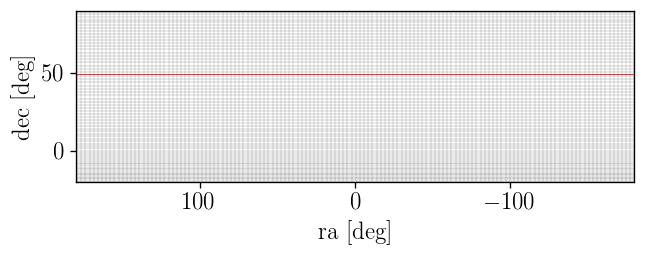

In [46]:
save_fn = f'{prefix}/pixel_grid.png'
fig, ax = plt.subplots()
for a in ra_grid_edges[::10]:
    ax.axvline(np.rad2deg(a), color='k', lw=0.1)
for a in dec_grid_edges[::10]:
    ax.axhline(np.rad2deg(a), color='k', lw=0.1)
ax.axhline(np.rad2deg(CHIME_dec), color='r', lw=0.5)
ax.set(xlim=CHIME_extent[:2], ylim=CHIME_extent[2:4], aspect=1)
ax.set(xlabel='ra [deg]', ylabel='dec [deg]')
plt.savefig(save_fn)
print(f'Plot saved: {save_fn}')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/haslam.png


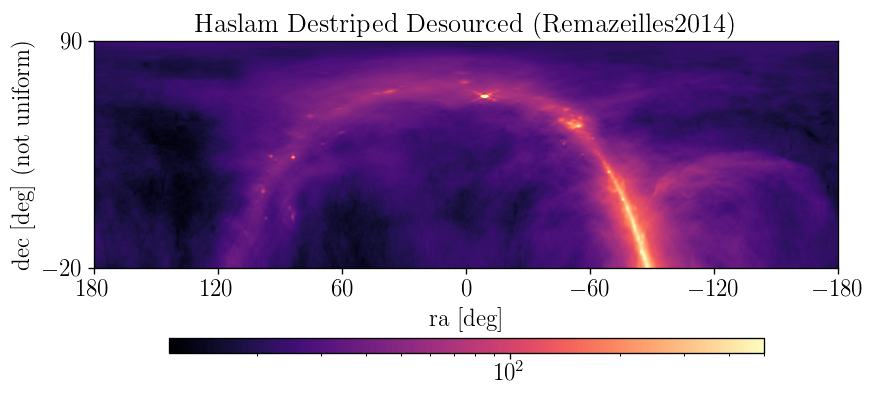

In [47]:
plot_radec(haslam_dsds_map, extent=CHIME_extent, vmax=500,
           title=r'Haslam Destriped Desourced (Remazeilles2014)', cmap='magma',
           save_fn=f'{prefix}/haslam.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/nfw.png


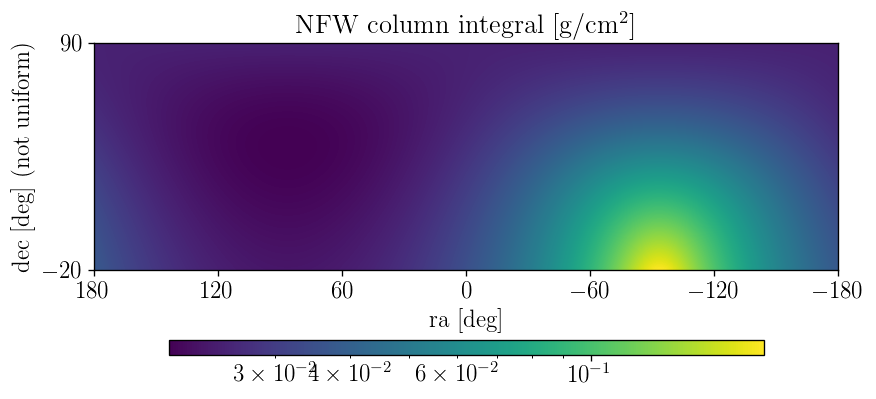

In [48]:
plot_radec(rho_integral_map, extent=CHIME_extent,
           title=r'NFW column integral [g/cm$^2$]', cmap='viridis',
           save_fn=f'{prefix}/nfw.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/naive_gegenschein.png


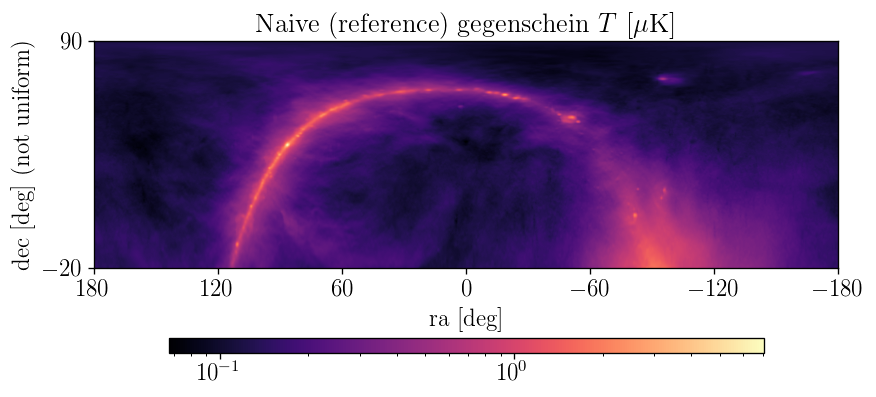

In [49]:
plot_radec(gegen_temp_map * 1e6, extent=CHIME_extent,
           title=r'Naive (reference) gegenschein $T$ [$\mu$K]', cmap='magma',
           save_fn=f'{prefix}/naive_gegenschein.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/reference_forwardschein.png


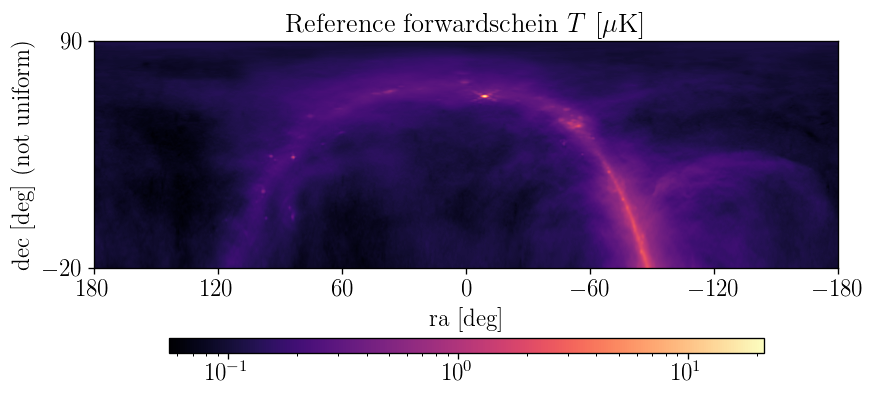

In [50]:
plot_radec(forward_temp_map * 1e6, extent=CHIME_extent,
           title=r'Reference forwardschein $T$ [$\mu$K]', cmap='magma',
           save_fn=f'{prefix}/reference_forwardschein.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/exposure.png


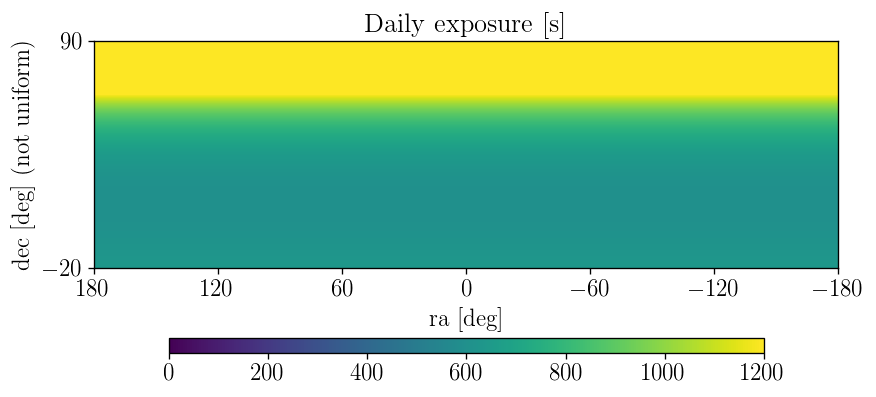

In [51]:
plot_radec(exposure_map, extent=CHIME_extent, log_norm=False,
           title='Daily exposure [s]', vmax=1200, vmin=0, cmap='viridis',
           save_fn=f'{prefix}/exposure.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/gegenschein_S_N.png


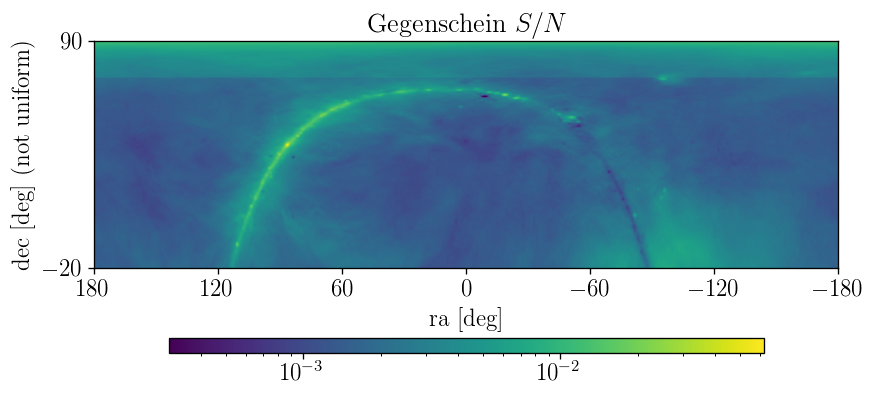

In [52]:
plot_radec(np.clip(SNR_g_s, 3e-4, None), extent=CHIME_extent,
           title=r'Gegenschein $S/N$', cmap='viridis',
           save_fn=f'{prefix}/gegenschein_S_N.png')

Plot saved: ../data/estimates/plots_field_AHgamma0p8/dependence_pixels.png


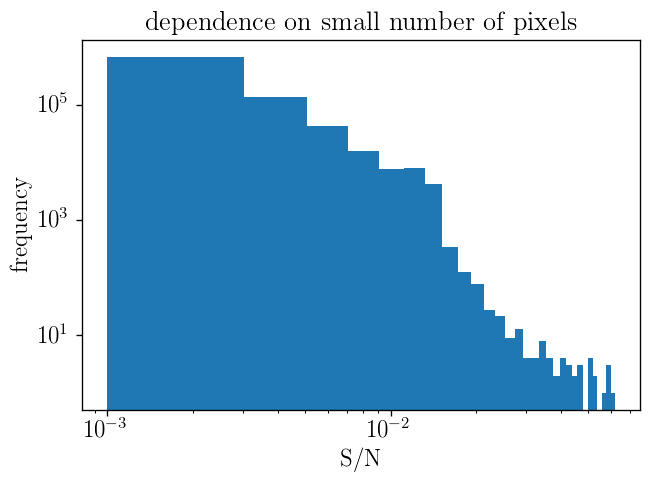

In [53]:
save_fn = f'{prefix}/dependence_pixels.png'
fig, ax = plt.subplots()
ax.hist(SNR_g_s[SNR_g_s>1e-3], bins=30)
ax.set(xscale='log', yscale='log')
ax.set(xlabel='S/N', ylabel='frequency',
       title='dependence on small number of pixels')
plt.savefig(save_fn)
print(f'Plot saved: {save_fn}')